# Hospital Readmissions Data Analysis and Recommendations for Reduction

### Background
In October 2012, the US government's Center for Medicare and Medicaid Services (CMS) began reducing Medicare payments for Inpatient Prospective Payment System hospitals with excess readmissions. Excess readmissions are measured by a ratio, by dividing a hospital’s number of “predicted” 30-day readmissions for heart attack, heart failure, and pneumonia by the number that would be “expected,” based on an average hospital with similar patients. A ratio greater than 1 indicates excess readmissions.

### Exercise Directions

In this exercise, you will:
+ critique a preliminary analysis of readmissions data and recommendations (provided below) for reducing the readmissions rate
+ construct a statistically sound analysis and make recommendations of your own 

More instructions provided below. Include your work **in this notebook and submit to your Github account**. 

### Resources
+ Data source: https://data.medicare.gov/Hospital-Compare/Hospital-Readmission-Reduction/9n3s-kdb3
+ More information: http://www.cms.gov/Medicare/medicare-fee-for-service-payment/acuteinpatientPPS/readmissions-reduction-program.html
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
****

In [161]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bokeh.plotting as bkp
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.stats as stats
import seaborn as sns
import math
from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr
from statsmodels.formula.api import ols

In [11]:
# read in readmissions data provided
hospital_read_df = pd.read_csv('cms_hospital_readmissions.csv')
hospital_read_df.head()

,Hospital Name,Provider Number,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date
0,FROEDTERT MEMORIAL LUTHERAN HOSPITAL,520177,WI,READM-30-HIP-KNEE-HRRP,242,NaN,1.9095,10.8,5.6,38.0,07/01/2010,06/30/2013
1,PROVIDENCE HOSPITAL,90006,DC,READM-30-HIP-KNEE-HRRP,247,NaN,1.7521,9.2,5.3,33.0,07/01/2010,06/30/2013
2,BEAUFORT COUNTY MEMORIAL HOSPITAL,420067,SC,READM-30-HIP-KNEE-HRRP,586,NaN,1.5836,7.6,4.8,53.0,07/01/2010,06/30/2013
3,ADVOCATE CHRIST HOSPITAL & MEDICAL CENTER,140208,IL,READM-30-HIP-KNEE-HRRP,965,NaN,1.5760,9.0,5.7,95.0,07/01/2010,06/30/2013
4,BRAZOSPORT REGIONAL HEALTH SYSTEM,450072,TX,READM-30-HIP-KNEE-HRRP,149,NaN,1.5308,8.2,5.4,20.0,07/01/2010,06/30/2013


****
## Preliminary Analysis

In [13]:
# deal with missing and inconvenient portions of data 
clean_hospital_read_df = hospital_read_df[hospital_read_df['Number of Discharges'] != 'Not Available']
clean_hospital_read_df.loc[:, 'Number of Discharges'] = clean_hospital_read_df['Number of Discharges'].astype(int)
clean_hospital_read_df = clean_hospital_read_df.sort_values('Number of Discharges')
clean_hospital_read_df.head()

C:\Users\TimusLetap\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Hospital Name,Provider Number,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date
16857,THREE RIVERS MEDICAL CENTER,180128,KY,READM-30-HIP-KNEE-HRRP,0,7.0,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013
14582,SELLS INDIAN HEALTH SERVICE HOSPITAL,30074,AZ,READM-30-COPD-HRRP,0,7.0,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013
15606,PHS INDIAN HOSPITAL AT PINE RIDGE,430081,SD,READM-30-AMI-HRRP,0,7.0,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013
15615,FLORIDA STATE HOSPITAL UNIT 31 MED,100298,FL,READM-30-COPD-HRRP,0,7.0,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013
14551,GREENE COUNTY HOSPITAL,10051,AL,READM-30-AMI-HRRP,0,7.0,NaN,NaN,NaN,NaN,07/01/2010,06/30/2013


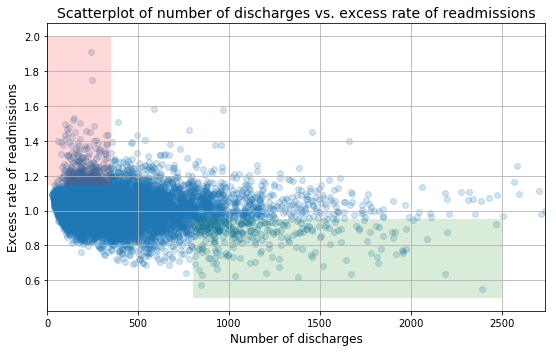

In [8]:
# generate a scatterplot for number of discharges vs. excess rate of readmissions
# lists work better with matplotlib scatterplot function
x = [a for a in clean_hospital_read_df['Number of Discharges'][81:-3]]
y = list(clean_hospital_read_df['Excess Readmission Ratio'][81:-3])

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2)

ax.fill_between([0,350], 1.15, 2, facecolor='red', alpha = .15, interpolate=True)
ax.fill_between([800,2500], .5, .95, facecolor='green', alpha = .15, interpolate=True)

ax.set_xlim([0, max(x)])
ax.set_xlabel('Number of discharges', fontsize=12)
ax.set_ylabel('Excess rate of readmissions', fontsize=12)
ax.set_title('Scatterplot of number of discharges vs. excess rate of readmissions', fontsize=14)

ax.grid(True)
fig.tight_layout()

****

## Preliminary Report

Read the following results/report. While you are reading it, think about if the conclusions are correct, incorrect, misleading or unfounded. Think about what you would change or what additional analyses you would perform.

**A. Initial observations based on the plot above**
+ Overall, rate of readmissions is trending down with increasing number of discharges
+ With lower number of discharges, there is a greater incidence of excess rate of readmissions (area shaded red)
+ With higher number of discharges, there is a greater incidence of lower rates of readmissions (area shaded green) 

**B. Statistics**
+ In hospitals/facilities with number of discharges < 100, mean excess readmission rate is 1.023 and 63% have excess readmission rate greater than 1 
+ In hospitals/facilities with number of discharges > 1000, mean excess readmission rate is 0.978 and 44% have excess readmission rate greater than 1 

**C. Conclusions**
+ There is a significant correlation between hospital capacity (number of discharges) and readmission rates. 
+ Smaller hospitals/facilities may be lacking necessary resources to ensure quality care and prevent complications that lead to readmissions.

**D. Regulatory policy recommendations**
+ Hospitals/facilties with small capacity (< 300) should be required to demonstrate upgraded resource allocation for quality care to continue operation.
+ Directives and incentives should be provided for consolidation of hospitals and facilities to have a smaller number of them with higher capacity and number of discharges.

****
<div class="span5 alert alert-info">
### Exercise

Include your work on the following **in this notebook and submit to your Github account**. 

A. Do you agree with the above analysis and recommendations? Why or why not?
   
B. Provide support for your arguments and your own recommendations with a statistically sound analysis:

   1. Setup an appropriate hypothesis test.
   2. Compute and report the observed significance value (or p-value).
   3. Report statistical significance for $\alpha$ = .01. 
   4. Discuss statistical significance and practical significance. Do they differ here? How does this change your recommendation to the client?
   5. Look at the scatterplot above. 
      - What are the advantages and disadvantages of using this plot to convey information?
      - Construct another plot that conveys the same information in a more direct manner.



You can compose in notebook cells using Markdown: 
+ In the control panel at the top, choose Cell > Cell Type > Markdown
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
</div>
****

# Do you agree with the above analysis and recommendations? Why or why not?
* I do not agree with the analysis completely due to the majority of the analysis being determined by the graphical representation
* The graph is quite ambiguaous and not very definitive of the statements
* There is no support for the statistical component with calculations
* The data preprocessing was done properly by dropping rows with NaN values
* No hypothesis testing done to allow for analysis of discharges by grouping into < 100 and > 1000
* Conclusion is not supported with concrete evidence
* There is confusion when relating to the policy recommendation with statistical component where facilities with discharge rate < 100 was used and recommendation is for facilities with capacity for < 300 which can generate some confusion on observations


In [14]:
# Analyze dataframe
hospital_read_df.describe()

,Provider Number,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions
count,16860.000000,3129.000000,13731.000000,13731.000000,13731.000000,11497.000000
mean,263516.943654,2.905401,1.002582,16.916532,16.866135,63.633731
std,160146.191702,2.074384,0.091088,6.197542,5.989652,59.540296
min,10001.000000,1.000000,0.549500,2.700000,2.900000,11.000000
25%,110181.500000,1.000000,0.949500,15.200000,15.800000,24.000000
50%,250157.000000,1.000000,0.997100,18.500000,18.500000,45.000000
75%,390138.250000,5.000000,1.052350,21.100000,21.100000,82.000000
max,670091.000000,7.000000,1.909500,32.800000,29.400000,879.000000


In [16]:
# Determine shape of dataframe
hospital_read_df.shape

(16860, 12)

In [52]:
# Determine number of NaN values
hospital_read_df.isnull().sum()

Hospital Name                     0
Provider Number                   0
State                             0
Measure Name                      0
Number of Discharges              0
Footnote                      13731
Excess Readmission Ratio       3129
Predicted Readmission Rate     3129
Expected Readmission Rate      3129
Number of Readmissions         5363
Start Date                        0
End Date                          0
dtype: int64

In [19]:
# Remove NaN values and assign variable 
Nan=hospital_read_df[hospital_read_df['Number of Discharges']=='Not Available']
Nan.isnull().sum()

Hospital Name                    0
Provider Number                  0
State                            0
Measure Name                     0
Number of Discharges             0
Footnote                      2234
Excess Readmission Ratio      3048
Predicted Readmission Rate    3048
Expected Readmission Rate     3048
Number of Readmissions        5282
Start Date                       0
End Date                         0
dtype: int64

In [24]:
# View shape of dataframe without NaN
hospital_df=hospital_read_df[hospital_read_df['Number of Discharges']!='Not Available']
hospital_df.shape

(11578, 12)

In [27]:
hospital_df=hospital_df[hospital_df['Number of Readmissions'].notnull()]

In [28]:
hospital_df.head()

,Hospital Name,Provider Number,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date
0,FROEDTERT MEMORIAL LUTHERAN HOSPITAL,520177,WI,READM-30-HIP-KNEE-HRRP,242,NaN,1.9095,10.8,5.6,38.0,07/01/2010,06/30/2013
1,PROVIDENCE HOSPITAL,90006,DC,READM-30-HIP-KNEE-HRRP,247,NaN,1.7521,9.2,5.3,33.0,07/01/2010,06/30/2013
2,BEAUFORT COUNTY MEMORIAL HOSPITAL,420067,SC,READM-30-HIP-KNEE-HRRP,586,NaN,1.5836,7.6,4.8,53.0,07/01/2010,06/30/2013
3,ADVOCATE CHRIST HOSPITAL & MEDICAL CENTER,140208,IL,READM-30-HIP-KNEE-HRRP,965,NaN,1.5760,9.0,5.7,95.0,07/01/2010,06/30/2013
4,BRAZOSPORT REGIONAL HEALTH SYSTEM,450072,TX,READM-30-HIP-KNEE-HRRP,149,NaN,1.5308,8.2,5.4,20.0,07/01/2010,06/30/2013


In [29]:
hospital_df['Number of Discharges']=pd.to_numeric(hospital_df['Number of Discharges'])

In [30]:
hospital_df.isnull().sum()

Hospital Name                     0
Provider Number                   0
State                             0
Measure Name                      0
Number of Discharges              0
Footnote                      11497
Excess Readmission Ratio          0
Predicted Readmission Rate        0
Expected Readmission Rate         0
Number of Readmissions            0
Start Date                        0
End Date                          0
dtype: int64

In [34]:
# Hospital data correlations
hospital_df.head()
hospital_df.corr()

,Provider Number,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions
Provider Number,1.000000,-0.008849,NaN,-0.012112,-0.009049,-0.003710,-0.009099
Number of Discharges,-0.008849,1.000000,NaN,-0.097398,-0.135163,-0.131091,0.791272
Footnote,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Excess Readmission Ratio,-0.012112,-0.097398,NaN,1.000000,0.200039,-0.031104,0.117600
Predicted Readmission Rate,-0.009049,-0.135163,NaN,0.200039,1.000000,0.965420,0.361033
Expected Readmission Rate,-0.003710,-0.131091,NaN,-0.031104,0.965420,1.000000,0.330527
Number of Readmissions,-0.009099,0.791272,NaN,0.117600,0.361033,0.330527,1.000000


In [163]:
# Estimate the Model
#x = hospital_df["Number of Discharges"]
#x = sm.add_constant(x)
mod = ols('hospital_df["Excess Readmission Ratio"] ~ hospital_df["Number of Discharges"]', hospital_df).fit(cov_type = "HC1")
mod.summary()

C:\Users\TimusLetap\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       OLS Regression Results                                      
===================================================================================================
Dep. Variable:     hospital_df["Excess Readmission Ratio"]   R-squared:                       0.009
Model:                                                 OLS   Adj. R-squared:                  0.009
Method:                                      Least Squares   F-statistic:                     72.48
Date:                                     Fri, 27 Oct 2017   Prob (F-statistic):           1.89e-17
Time:                                             01:21:32   Log-Likelihood:                 11178.
No. Observations:                                    11497   AIC:                        -2.235e+04
Df Residuals:                                        11495   BIC:                        -2.234e+04
Df Model:                                                1                                         
Covariance Type:                                       HC1                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               1.0181      0.001    755.438      0.000       1.015       1.021
hospital_df["Number of Discharges"] -2.901e-05   3.41e-06     -8.514      0.000   -3.57e-05   -2.23e-05
==============================================================================
Omnibus:                     1666.940   Durbin-Watson:                   0.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6839.197
Skew:                           0.671   Prob(JB):                         0.00
Kurtosis:                       6.532   Cond. No.                         741.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

* The regression results show a negative relationship between 'Number of Discharges' and 'Excess Readmission Ratio' with larger facilities having less readmissions
* There is not enough support for benefit of smaller institutions to behave like larger institutions for practice as significance value is very low to support such implementations with positive results

In [164]:
# Calculate r squared
r_squared= r**2
r_squared

0.009486370404

In [57]:
# Total number of hospitals with no missing data
n= hospital_df.shape[0]
n

11497

* Sample size of 11497 is sufficient to make calculations and observations from and thusly considered sufficient

In [187]:
# Mean
mean_dis= (np.mean(hospital_df['Number of Discharges']))
print (mean_dis)

# Variance
var_dis= (np.var(hospital_df['Number of Discharges']))
print (var_dis)

#Standard deviation
std_dis= (np.std(hospital_df['Number of Discharges']))
print (std_dis)

365.4662085761503
95321.1052554607
308.74116223053363


In [166]:
# Calculate Pearson Correlation Coefficient
rho, p= stats.pearsonr(x= hospital_df['Number of Discharges'], y= hospital_df['Excess Readmission Ratio'])
print( "The correlation coefficient is %.3f and its p-value is %.3f." % (rho, p))

The correlation coefficient is -0.097 and its p-value is 0.000.


* Pearson Correlation suggests that there is a positive direct correlation between Discharges and Readmissions
* With the p-value being so close to zero we can safely assume that the 'Number of Discharges' is not a good predictor of 'Excess Readmission Ratio'
* This is an instance of where the p-value provides us with significance but does not reflect on the data, p-value scrutiny

In [207]:
# T-test
t_test= stats.ttest_ind(hospital_df['Number of Discharges'], hospital_df['Excess Readmission Ratio'], equal_var=False)
t_test

Ttest_indResult(statistic=126.56894236253518, pvalue=0.0)

* The p-value suggest the rejection of the null hypothesis suggesting that the data has abnormalities

In [142]:
# T-test with alpha = 0.01
stats.t.interval(alpha = 0.01,              
                 df = 11497, 
                 loc= hospital_df['Number of Discharges'].mean())  

(365.45367483405863, 365.47874231824193)

* Significance level of 1% narrows the chances of capturing the true mean

In [143]:
# T-test with alpha = 0.99
stats.t.interval(alpha = 0.99,              
                 df = 11497, 
                 loc= hospital_df['Number of Discharges'].mean()) 

(362.8899515683193, 368.04246558398125)

* Significance level of 99% widens the chances of capturing the true mean making it likely to reject the null hypothesis

In [184]:
def ecdf(hospital_df):
    
    # Number of data points: n
    n = len(hospital_df)

    # x-data for the ECDF: x
    x = np.sort(hospital_df)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

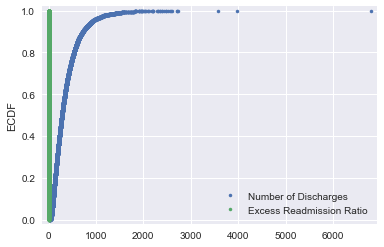

In [205]:
x1, y1 = ecdf(hospital_df['Number of Discharges'])
x2, y2 = ecdf(hospital_df['Excess Readmission Ratio'])

# Generate plot
_ = plt.plot(x1, y1, marker='.', linestyle='none')
_ = plt.plot(x2, y2, marker='.', linestyle='none')

# Make the margins nice
plt.margins(0.02)

# Label the axes
_ = plt.ylabel('ECDF')
_ = plt.legend(('Number of Discharges', 'Excess Readmission Ratio'), loc= 'lower right')

# Display the plot
plt.show()

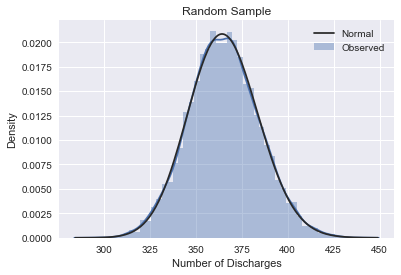

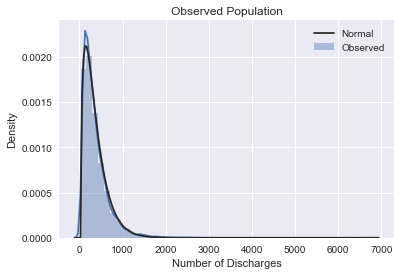

In [202]:
discharge = np.random.gamma(mean_dis, size=11497)
_= sns.distplot(discharge, kde=True, fit=stats.gamma)
_= plt.xlabel('Number of Discharges')
_= plt.ylabel('Density')
_= plt.title('Random Sample')
_= plt.legend(('Normal', 'Observed'))
plt.show()


_= sns.distplot(hospital_df['Number of Discharges'], kde=True, fit=stats.gamma)
_= plt.xlabel('Number of Discharges')
_= plt.ylabel('Density')
_= plt.title('Observed Population')
_= plt.legend(('Normal', 'Observed'))
plt.show()

* From the normalization curve we can see that compared to random sample the observed populaiton does not have a normal distribution

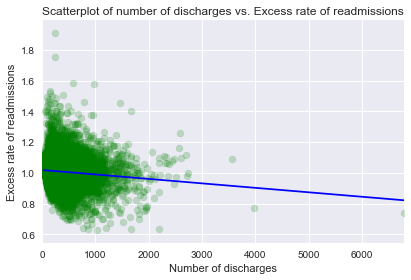

In [181]:
# store fit results in clearer labels
intercept = mod.params[0]
slope = mod.params[1]

# regenerate improved scatter plot

# generate a scatterplot for number of discharges vs. excess rate of readmissions
# lists work better with matplotlib scatterplot function
x = [a for a in hospital_df['Number of Discharges'][:-3]]
y = list(hospital_df['Excess Readmission Ratio'][:-3])

fig, ax = plt.subplots()
ax.scatter(x, y,alpha=0.2, c= 'green')

points = np.linspace(hospital_df['Number of Discharges'][:-3].min(), hospital_df['Number of Discharges'][:-3].max(), 2)
plt.plot(points, slope*points + intercept, c= 'blue')

ax.set_xlim([0, max(x)])
ax.set_xlabel('Number of discharges')
ax.set_ylabel('Excess rate of readmissions')
ax.set_title('Scatterplot of number of discharges vs. Excess rate of readmissions')

ax.grid(True)
fig.tight_layout()


* Graphical inclusion of correlation line provides a better observation to draw insights from
* We can see from this that there is a negative linear regression in the realtionship between 'Number of Discharges' and 'Excess rate of readmissions' 
* The rate of discharges increasing has negative impact on readmissions, which show there is no substantial support of relationship between two factors

# Conclusion
* We are able to conclude that 'Number of Discharges' is not a significant correlation value to draw insight with respect to 'Excess Readmission Ratio'
* We are also able to determine that because of this lack of significance regulatory recommendations for smaller facilities to make upgrades would not provide a valuable impact but rather be more costly with less results